### MCMC Markov Chain Monte Carlo

modified from: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb

When we setup a Bayesian inference problem with $N$ unknowns, we are implicitly creating an $N$ dimensional space for the prior distributions to exist in. Associated with the space is an additional dimension, which we can describe as the surface, or curve, that sits on top of the space, that reflects the prior probability of a particular point. The surface on the space is defined by our prior distributions. 

F.i. if 2 priors are $\text{Exp}(3)$ and $\text{Exp}(10)$, then the space is all positive numbers on the 2-D plane, and the surface induced by the priors looks like a water fall that starts at the point (0,0) and flows over the positive numbers.

The plots below visualize this. The more more yellow the color, the more prior probability is assigned to that location. Conversely, areas with darker blue represent that our priors assign very low probability to that location.

In [8]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pymc3 as pm
import theano.tensor as T
import sys
sys.path.insert(0, 'helper_functions/')
from utilities import remove_borders

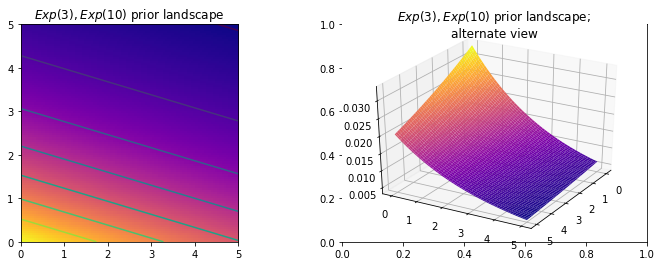

In [3]:
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(1,2,figsize=[12,4])
exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = ax[0].contour(X, Y, M)
im = ax[0].imshow(M, interpolation='none', origin='lower',
                cmap='plasma', extent=(0, 5, 0, 5))
_ = ax[0].set(title ="$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap='plasma')
ax.view_init(azim=390)
_ = ax.set(title = "$Exp(3), Exp(10)$ prior landscape; \nalternate view")

If these surfaces describe our prior distributions on the unknowns, what happens to our space after we incorporate our observed data $X$? The data $X$ does not change the space, but it changes the surface of the space by pulling and stretching the fabric of the prior surface to reflect where the true parameters likely live. More data means more pulling and stretching, and our original shape becomes mangled or insignificant compared to the newly formed shape. Less data, and our original shape is more present. Regardless, the resulting surface describes the posterior distribution.

In [5]:
# sample size of data we observe
N = 5

# the true parameters that we don't know
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observed (2-dimensional,sample size = {}):".format(N, data))

# plotting details.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

observed (2-dimensional,sample size = 5):


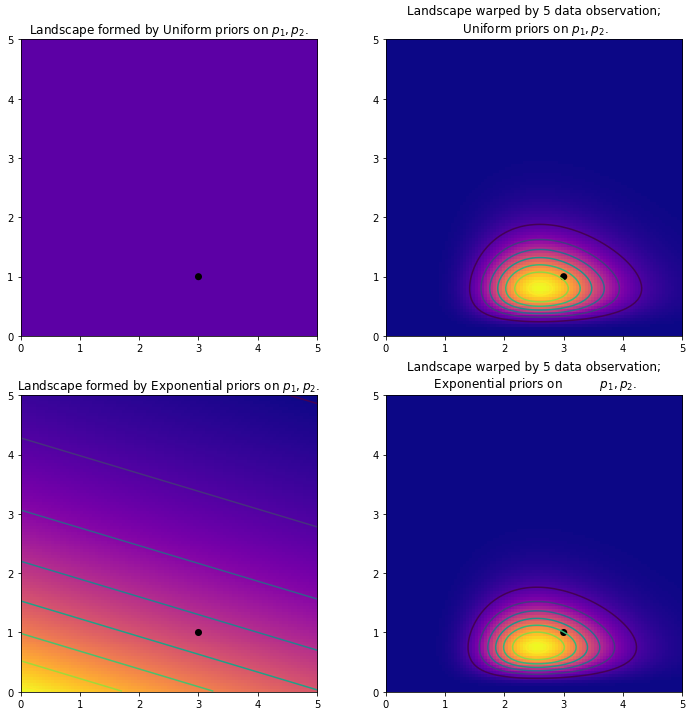

In [6]:
fig, ax = plt.subplots(2,2, figsize=[12,12])
ax = ax.ravel()

uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = ax[0].imshow(M, interpolation='none', origin='lower',
                cmap='plasma', vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
ax[0].scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
ax[0].set(title = "Landscape formed by Uniform priors on $p_1, p_2$.")

ax[1].contour(x, y, M * L)
im = ax[1].imshow(M * L, interpolation='none', origin='lower',
                cmap='plasma', extent=(0, 5, 0, 5))
ax[1].scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
ax[1].set(title = "Landscape warped by {} data observation;\n Uniform priors on \
$p_1, p_2$.".format(N))


exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
ax[2].contour(x, y, M)
im = ax[2].imshow(M, interpolation='none', origin='lower',
                cmap='plasma', extent=(0, 5, 0, 5))
ax[2].scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
ax[2].set(title = "Landscape formed by Exponential priors on $p_1, p_2$.")

# This is the likelihood times prior, that results in the posterior.
ax[3].contour(x, y, M * L)
im = ax[3].imshow(M * L, interpolation='none', origin='lower',
                 cmap='plasma', extent=(0, 5, 0, 5))
ax[3].scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
ax[3].set(title = "Landscape warped by {} data observation;\n Exponential priors on\
          $p_1, p_2$.".format(N))

for i, x in enumerate(ax):
    ax[i].set(xlim = (0,5), ylim = (0,5))

**We should explore the deformed posterior space generated by our prior surface and observed data to find the posterior mountain** Recall that MCMC returns samples from the *posterior* distribution, not the distribution itself. MCMC intelligently searches the space meaning it will hopefully converge towards the areas of high posterior probability. MCMC does this by exploring nearby positions and moving into areas with higher probability. Again, perhaps "converge" is not an accurate term to describe MCMC's progression. Converging usually implies moving towards a point in space, but MCMC moves towards a broader area in the space and randomly walks in that area, picking up samples from that area.

- step 1) Start at current position.
- step 2) Propose moving to a new position
- step 3) Accept/Reject the new position based on the position's adherence to the data and prior distributions (ask if the pebble likely came from the mountain).
- step 4) If you accept: Move to the new position. Return to step 1. Else: Do not move to new position. Return to step 1.
- step 5) After a large number of iterations, return all accepted positions.

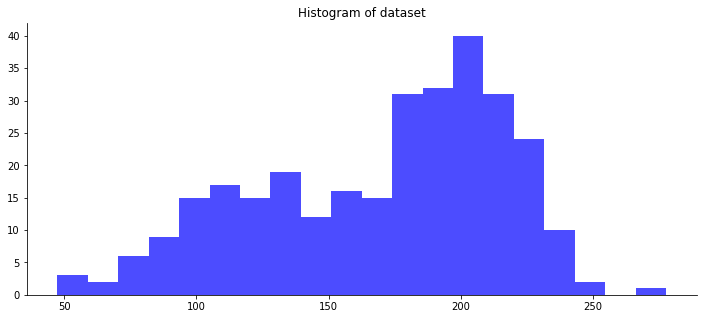

In [7]:
data = np.loadtxt('data/mixture_data.csv', delimiter=',')
fig, ax = plt.subplots(figsize=[12,5])
ax.hist(data, bins=20, color='blue', histtype="stepfilled", alpha=0.7)
ax.set(ylim = (0, None), title = "Histogram of dataset")
remove_borders(ax)

In Bayesian modeling always think HOW the data might have been created. Here the following might apply:

- step 1) for each data point, choose cluster 1 with probability $p$, else choose cluster 2.
- step 2) assign data points to clusters

**An appropriate way to assign data points to clusters is to use a PyMC3 Categorical stochastic variable**. Its parameter is a $k$-length array of probabilities that must sum to one and its value attribute is an integer between 0 and $k-1$ randomly chosen according to the crafted array of probabilities (In our case $k=2$)

- step 3) Looking at the dataset, the standard deviations of the two Normals are clearly different. To maintain ignorance of what the standard deviations might be, we will initially model them as uniform on 0 to 100. We will include both standard deviations in our model using a single line of PyMC3 code:

    sds = pm.Uniform("sds", 0, 100, shape=2)

- step 4) specify priors on the centers ($\mu$) of the clusters. Eye-balling these estimates gives approximatley $\mu_0 = 120$ and $\mu_1 = 190$ and $\sigma_0 = \sigma_1 = 10$.

- step 5) Draw a random variate from a Normal distribution with parameters $\mu_i$ and $\sigma_i$ where $i$ was chosen in step 1.

- step 6) combine it with the observations

In [55]:
with pm.Model() as model:
    #step 1
    p1 = pm.Uniform('p', 0, 1) # p∼Uniform(lower=0.0, upper=1.0)
    p2 = 1 - p1 # a theano.tensor.var.TensorVariable
    p = T.stack([p1, p2]) 
    #step2
    assignment = pm.Categorical('assigment', p, shape = data.shape[0],
                               testval = np.random.randint(low= 0,high = 2, 
                                                           size = data.shape[0]))

print("prior assignment, with p = {}".format(p1.tag.test_value))
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.5
[1 1 1 1 1 0 1 0 1 1]


In [56]:
with model:
    # step 3
    sds = pm.Uniform("sds", 0, 100, shape=2)
    # step 4 
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    # step 5
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Random assignments: ", assignment.tag.test_value[:5])
print("Assigned center: ", center_i.tag.test_value[:5])
print("Assigned standard deviation: ", sd_i.tag.test_value[:5])

Random assignments:  [1 1 1 1 1]
Assigned center:  [190. 190. 190. 190. 190.]
Assigned standard deviation:  [50. 50. 50. 50. 50.]


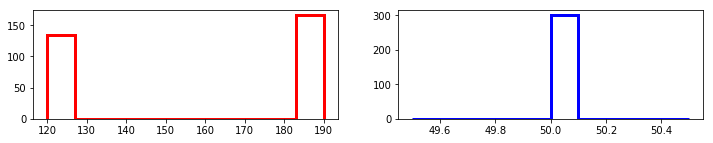

In [60]:
fig, ax = plt.subplots(1,2, figsize=[12,2])
_ = ax[0].hist(center_i.tag.test_value, bins=10, histtype='step',edgecolor='r',linewidth=3)
_ = ax[1].hist(sd_i.tag.test_value, bins=10, histtype='step',edgecolor='blue',linewidth=3)

Now we need to do some sampling and explore the space that we have so far defined by defining the sampling methods, in this case **Metropolis()** for our continuous variables and **ElemwiseCategorical()** for our categorical variable (assigments). We will use these sampling methods together to explore the space by using sample( iterations, step ), where iterations is the number of steps you wish the algorithm to perform and step is the way in which you want to handle those steps. We use our combination of Metropolis() and ElemwiseCategorical() for the step and sample 25000 iterations below:

In [62]:
with model:
    step1 = pm.Metropolis(vars = [p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
# ElemwiseCategorical is deprecated now use: CategoricalGibbsMetropolis()
    trace = pm.sample(25000, step = [step1, step2])

/home/diederik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>ElemwiseCategorical: [assigment]
Sampling 2 chains: 100%|██████████| 51000/51000 [03:03<00:00, 277.32draws/s]
/home/diederik/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 10% for some parameters.


In [80]:
trace['centers']

array([[110.45862885, 196.1127433 ],
       [110.45862885, 196.1127433 ],
       [110.45862885, 196.1127433 ],
       ...,
       [127.15573384, 200.40608945],
       [127.40145137, 203.52349325],
       [123.64757946, 203.07233376]])

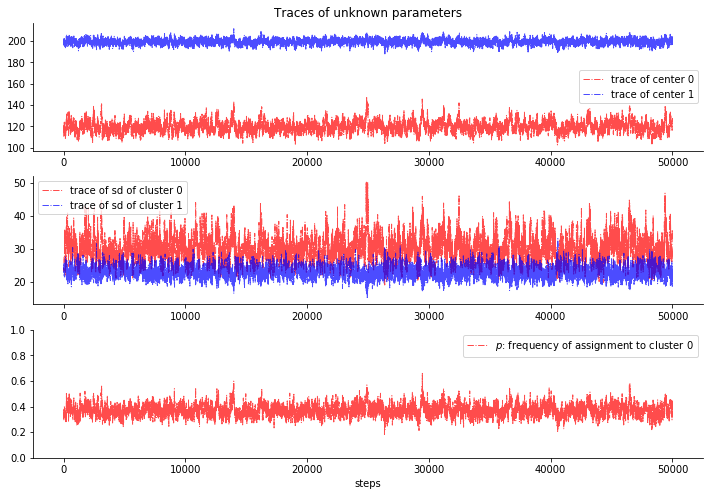

In [90]:
# sample variables
center_trace = trace["centers"]
p_trace = trace["p"]
std_trace = trace["sds"]

# plt config 
fig, ax = plt.subplots(3,1, figsize=[12,8])
col = ['red', 'blue'] 
trace_config = {'lw': 1, 'alpha': .7, 'ls': 'dashdot'}

ax[0].plot(center_trace[:, 0], label="trace of center 0", c=col[0], **trace_config)
ax[0].plot(center_trace[:, 1], label="trace of center 1", c=col[1], **trace_config)
ax[0].set(title = 'Traces of unknown parameters')

ax[1].plot(std_trace[:, 0], label="trace of sd of cluster 0", c=col[0], **trace_config)
ax[1].plot(std_trace[:, 1], label="trace of sd of cluster 1", c=col[1], **trace_config)

ax[2].plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=col[0], **trace_config)
ax[2].set(xlabel = 'steps', ylim = (0, 1))

for i, x in enumerate(ax.ravel()):
    remove_borders(ax[i])   
    ax[i].legend(loc='best')

Important to notice
:
- MCMC trace converges to **a distribution of possible points**
- Inference in the first points (say 1000, caled the burn-in period) is not recommended, as this is **unrelated to the final distribution we are interested in**.
- traces appear as `random walk` around the space --> the paths exhibit correlations with previous positions. Too much correlation is not good so it's somehting that needs to be diagnosed.
- to achieve further convergence, we can easily add more MCMC steps. The positions/steps are stored in the trace object so we can continue where we left off w/o overwriting previsously calculated values: 

In [91]:
with model:
    trace = pm.sample(50000, step=[step1, step2], trace=trace)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>ElemwiseCategorical: [assigment]
Sampling 2 chains: 100%|██████████| 101000/101000 [06:12<00:00, 271.36draws/s]
/home/diederik/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 10% for some parameters.


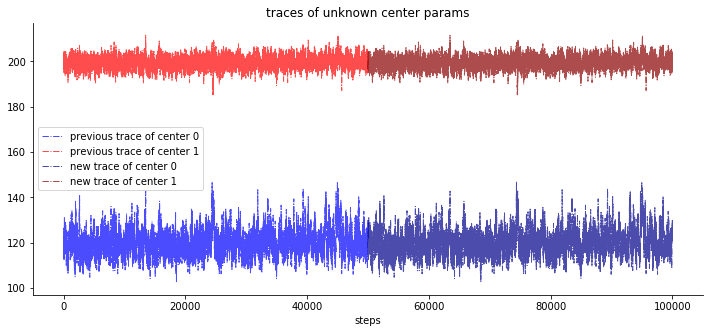

In [104]:
# variables
threshold = 50000
center_trace = trace["centers"][threshold:]
prev_center_trace = trace["centers"][:threshold]

# config
fig, ax = plt.subplots(figsize=[12,5])
trace_config = {'lw': 1, 'alpha': .7, 'ls': 'dashdot'}

x = np.arange(threshold)
ax.plot(x, prev_center_trace[:, 0], label="previous trace of center 0", c=col[1], 
        **trace_config)
ax.plot(x, prev_center_trace[:, 1], label="previous trace of center 1", c=col[0], 
        **trace_config)

x = np.arange(threshold, 2 * threshold)
ax.plot(x, prev_center_trace[:, 0], label="new trace of center 0", c='darkblue', 
        **trace_config)
ax.plot(x, prev_center_trace[:, 1], label="new trace of center 1", c='darkred', 
        **trace_config)
ax.set(title = 'traces of unknown center params', xlabel = 'steps')
ax.legend(loc='best')
remove_borders(ax)

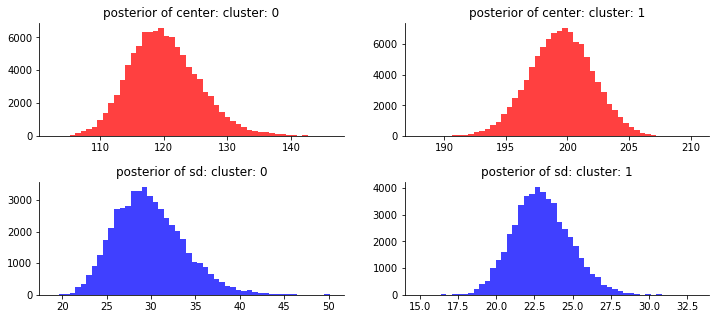

In [138]:
fig, ax = plt.subplots(2,2, figsize=[12,5])
fig.subplots_adjust(hspace=.4)
ax = ax.ravel()

ax[0].hist(center_trace[:,0], bins=50, color='red', alpha=.75)
ax[1].hist(center_trace[:,1], bins=50, color='red', alpha=.75)
ax[2].hist(std_trace[:,0], bins=50, color='blue', alpha=.75)
ax[3].hist(std_trace[:,1], bins=50, color='blue', alpha=.75)

for i, t, c in zip([0,1,2,3], ['0', '1', '0', '1'], ['center', 'center', 'sd', 'sd']):
    remove_borders(ax[i])
    ax[i].set(title = 'posterior of {}: cluster: {}'.format(c, t))

We also have **the posterior distributions for the labels of the data point, which is present in trace["assignment"]**. Below is a visualization of this. The y-axis represents a subsample of the posterior labels for each data point. The x-axis are the sorted values of the data points. A red square is an assignment to cluster 1, and a blue square is an assignment to cluster 0.



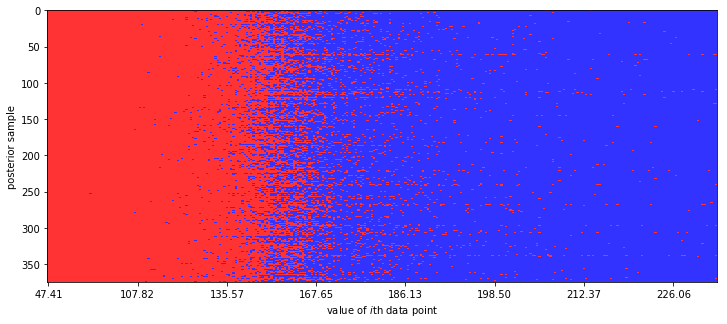

In [177]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(col)

fig, ax = plt.subplots(figsize=[12,5])

ax.imshow(trace['assigment'][::400, np.argsort(data)], cmap=cmap, aspect='auto', 
          alpha=.8)
_ = plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
_ = ax.set(ylabel = "posterior sample",  xlabel = "value of $i$th data point")

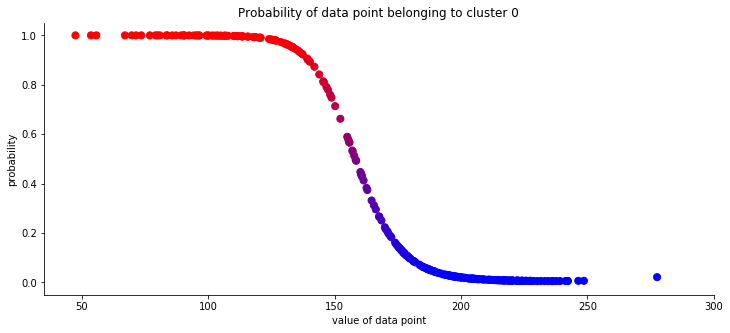

In [183]:
cmap = LinearSegmentedColormap.from_list("BMH", col)
assign_trace = trace["assigment"]

fig, ax = plt.subplots(figsize=[12,5])
ax.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
           c=assign_trace.mean(axis=0), s=50)
_ = ax.set(ylim = (-0.05, 1.05), xlim = (35, 300), 
       title = "Probability of data point belonging to cluster 0", 
       ylabel = "probability",  xlabel = "value of data point")
remove_borders(ax)